In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from gym_agro_carbon.models.context import ContextSpec, ContextEncoder
from gym_agro_carbon.models.reward import RewardSpec, RewardModel
from gym_agro_carbon.envs.grid import EnvSpec, AgroCarbonGridEnv

from gym_agro_carbon.evaluation.oracle import build_oracle_policy
from gym_agro_carbon.evaluation.regret import RegretTracker

from gym_agro_carbon.bandits.base import RandomBandit
from gym_agro_carbon.bandits.ucb import UCBBandit
from gym_agro_carbon.bandits.thompson import ThompsonSamplingBandit

In [3]:
H, W = 8, 10
T = 60

S = 8
M = 7
alpha = 0.6
seed = 123

context_spec = ContextSpec(S=S, M=M)
encoder = ContextEncoder(context_spec)

reward_spec = RewardSpec(
    context_spec=context_spec,
    alpha=alpha,
    sigma_c=0.05,
    sigma_y=0.05,
    tree_carbon_gain=0.50,
    tree_yield_gain=0.10,
)
reward_model = RewardModel(spec=reward_spec, encoder=encoder)

env_spec = EnvSpec(H=H, W=W, T=T, alpha=alpha, S=S, M=M, seed=seed)
env = AgroCarbonGridEnv(env_spec=env_spec, context_spec=context_spec, reward_model=reward_model)

oracle = build_oracle_policy(encoder=encoder, reward_model=reward_model, num_actions=env_spec.num_actions)
regret_tracker = RegretTracker(encoder=encoder, reward_model=reward_model, oracle=oracle)

In [4]:
def run_agent(env, agent, T, seed=0):
    obs, info = env.reset(seed=seed)
    agent.reset()
    regret_tracker.reset()

    rewards = []
    regrets = []
    trees = []

    for t in range(T):
        actions = agent.select_actions(obs)
        obs2, R, terminated, truncated, info2 = env.step(actions)

        agent.update(obs, actions, info2["reward_grid"])
        step_regret = regret_tracker.update(t=t, obs_context_ids=obs, actions_grid=actions)

        rewards.append(float(R))
        regrets.append(float(step_regret))
        trees.append(int(info2["num_agent_trees"]))

        obs = obs2
        if terminated or truncated:
            break

    return {
        "rewards": np.array(rewards, dtype=float),
        "regrets": np.array(regrets, dtype=float),
        "trees": np.array(trees, dtype=int),
    }


def cum(x):
    return np.cumsum(x)

In [5]:
agents = {
    "Random": RandomBandit(context_encoder=encoder, num_actions=env_spec.num_actions, seed=0),
    "UCB": UCBBandit(context_encoder=encoder, num_actions=env_spec.num_actions, seed=0, exploration_c=1.0),
    "Thompson": ThompsonSamplingBandit(context_encoder=encoder, num_actions=env_spec.num_actions, seed=0, mu0=0.0, sigma0=1.0),
}

results = {}
for name, agent in agents.items():
    results[name] = run_agent(env, agent, T=T, seed=seed)

{n: (results[n]["rewards"].sum(), results[n]["regrets"].sum()) for n in results}

{'Random': (np.float64(4292.974006652832), np.float64(408.00226163864136)),
 'UCB': (np.float64(4454.118515014648), np.float64(270.99769020080566)),
 'Thompson': (np.float64(4469.768844604492), np.float64(238.34740364551544))}

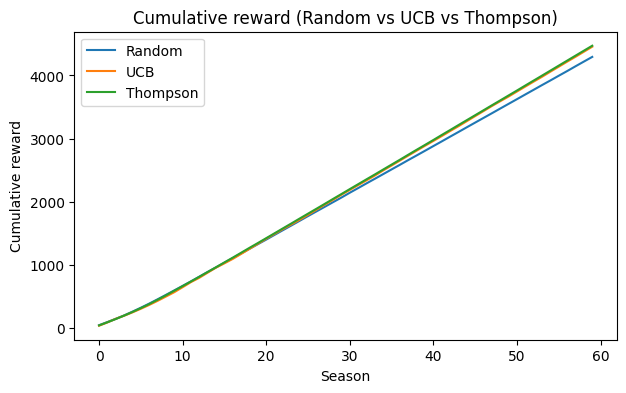

In [6]:
plt.figure(figsize=(7,4))
for name in results:
    plt.plot(cum(results[name]["rewards"]), label=f"{name}")
plt.xlabel("Season")
plt.ylabel("Cumulative reward")
plt.title("Cumulative reward (Random vs UCB vs Thompson)")
plt.legend()
plt.show()

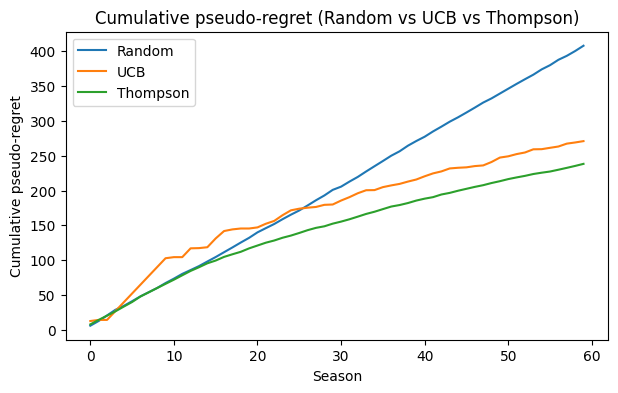

In [7]:
plt.figure(figsize=(7,4))
for name in results:
    plt.plot(cum(results[name]["regrets"]), label=f"{name}")
plt.xlabel("Season")
plt.ylabel("Cumulative pseudo-regret")
plt.title("Cumulative pseudo-regret (Random vs UCB vs Thompson)")
plt.legend()
plt.show()

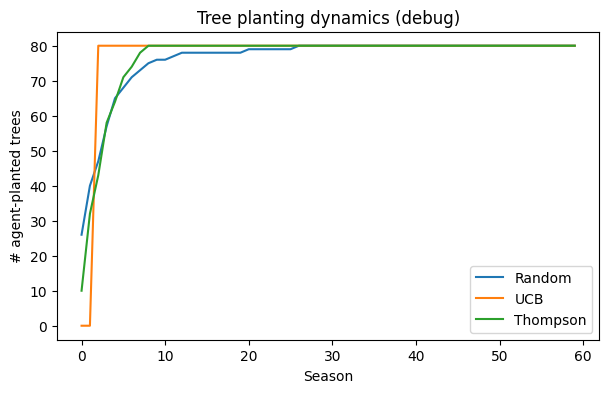

In [8]:
plt.figure(figsize=(7,4))
for name in results:
    plt.plot(results[name]["trees"], label=f"{name}")
plt.xlabel("Season")
plt.ylabel("# agent-planted trees")
plt.title("Tree planting dynamics (debug)")
plt.legend()
plt.show()